# **Transfer Learning y Fune tunning con DenseNet**

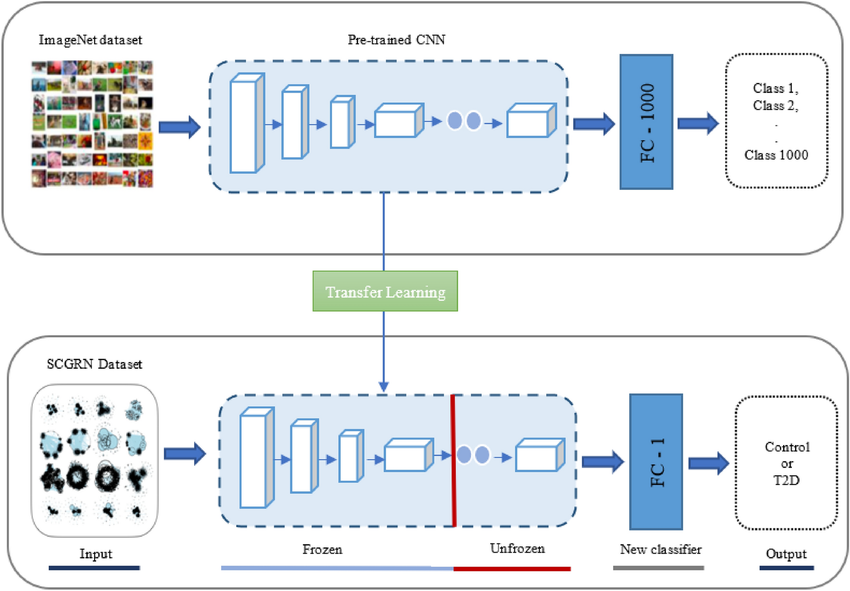

## **Instalación de Dependencias**

In [1]:
# Instalar dependencias principales
!pip install torch torchvision torchaudio --upgrade  # Versiones más recientes de PyTorch
!pip install Pillow pandas matplotlib scikit-learn tensorboard  # Para manejo de imágenes, gráficos y métricas

# Verificación de instalación
import torch
print(f"Versión de PyTorch: {torch.__version__}")
print(f"GPU disponible: {torch.cuda.is_available()}")  # Debe mostrar True si tienes GPU activa

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 888.1/888.1 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 132.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 73.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.2/287.2 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3

## **Importaciones**

In [2]:
# Librerías básicas
import os
from collections import defaultdict
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd

# PyTorch general
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import transforms, datasets, models

# Métricas y evaluación
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.model_selection import train_test_split

# TensorBoard (opcional)
from torch.utils.tensorboard import SummaryWriter

# Verificación de GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nDispositivo seleccionado: {device}")
print(f"Versión PyTorch: {torch.__version__}\n")


Dispositivo seleccionado: cuda
Versión PyTorch: 2.8.0+cu128



## **Montar Google Drive y Definir Rutas**

In [3]:
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


=== Estructura del dataset ===
✅ CascaraManzana: 1087 imágenes
✅ EnvoltoriosSnacks: 1012 imágenes
✅ HojasSecas: 1049 imágenes
✅ Facturas: 1016 imágenes
✅ GuantesLatex: 921 imágenes


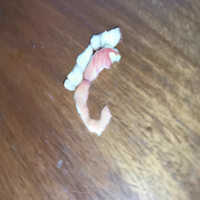

In [5]:
# Definir rutas
base_path = "/content/drive/MyDrive/IA2/DatasetBasura"

class_names = ["CascaraManzana", "EnvoltoriosSnacks", "HojasSecas", "Facturas", "GuantesLatex"]

# Verificación de estructura de carpetas
print("=== Estructura del dataset ===")
missing_folders = []
for class_name in class_names:
    class_path = os.path.join(base_path, class_name)
    if os.path.exists(class_path):
        print(f"✅ {class_name}: {len(os.listdir(class_path))} imágenes")
    else:
        missing_folders.append(class_name)
        print(f"❌ {class_name}: No encontrado")

if missing_folders:
    raise ValueError(f"Faltan carpetas: {missing_folders}")

# Mostrar ejemplo de imagen
sample_image_path = os.path.join(base_path, class_names[0], os.listdir(os.path.join(base_path, class_names[0]))[50])
display(Image.open(sample_image_path).resize((200, 200)))

## **Estructura y Partición del Dataset**

### **Parámetros iniciales**

In [6]:
# Configuración de partición
RANDOM_SEED = 42  # Para reproducibilidad
TEST_RATIO = 0.15
VAL_RATIO = 0.15

# Crear directorios temporales en Colab (no en Drive, es más rápido)
!mkdir -p /content/train /content/val /content/test

### **Función para dividir y copiar imágenes**

In [7]:
# Función auxiliar para crear splits balanceados
def split_and_copy_dataset(base_path, class_names, val_ratio, test_ratio, random_seed):
    for class_name in class_names:
        # Crear subcarpetas en train/val/test
        !mkdir -p /content/train/{class_name}
        !mkdir -p /content/val/{class_name}
        !mkdir -p /content/test/{class_name}

        # Listar imágenes de la clase actual
        class_path = os.path.join(base_path, class_name)
        images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # Dividir: train -> 70%, val -> 15%, test -> 15%
        train_val, test = train_test_split(images, test_size=test_ratio, random_state=random_seed)
        train, val = train_test_split(train_val, test_size=val_ratio/(1-test_ratio), random_state=random_seed)

        # Copiar archivos (usando comandos Linux para mayor velocidad)
        for img in train:
            !cp "{os.path.join(class_path, img)}" "/content/train/{class_name}/"
        for img in val:
            !cp "{os.path.join(class_path, img)}" "/content/val/{class_name}/"
        for img in test:
            !cp "{os.path.join(class_path, img)}" "/content/test/{class_name}/"

        print(f"[{class_name}] Train: {len(train)}, Val: {len(val)}, Test: {len(test)}")

# Ejecutar la partición
split_and_copy_dataset(base_path, class_names, VAL_RATIO, TEST_RATIO, RANDOM_SEED)

[CascaraManzana] Train: 760, Val: 163, Test: 164
[EnvoltoriosSnacks] Train: 708, Val: 152, Test: 152
[HojasSecas] Train: 733, Val: 158, Test: 158
[Facturas] Train: 710, Val: 153, Test: 153
[GuantesLatex] Train: 644, Val: 138, Test: 139


### **Verificación de resultados**

In [8]:
# Contar imágenes por split
def count_images(split_path):
    print(f"\n=== Conteo en {split_path} ===")
    for class_name in class_names:
        path = os.path.join(split_path, class_name)
        print(f"{class_name}: {len(os.listdir(path))} imágenes")

count_images("/content/train")
count_images("/content/val")
count_images("/content/test")


=== Conteo en /content/train ===
CascaraManzana: 760 imágenes
EnvoltoriosSnacks: 708 imágenes
HojasSecas: 733 imágenes
Facturas: 710 imágenes
GuantesLatex: 644 imágenes

=== Conteo en /content/val ===
CascaraManzana: 163 imágenes
EnvoltoriosSnacks: 152 imágenes
HojasSecas: 158 imágenes
Facturas: 153 imágenes
GuantesLatex: 138 imágenes

=== Conteo en /content/test ===
CascaraManzana: 164 imágenes
EnvoltoriosSnacks: 152 imágenes
HojasSecas: 158 imágenes
Facturas: 153 imágenes
GuantesLatex: 139 imágenes


## **Comprobación de Calidad del Dataset**

### **Análisis de distribución por clase (para detectar desbalance)**

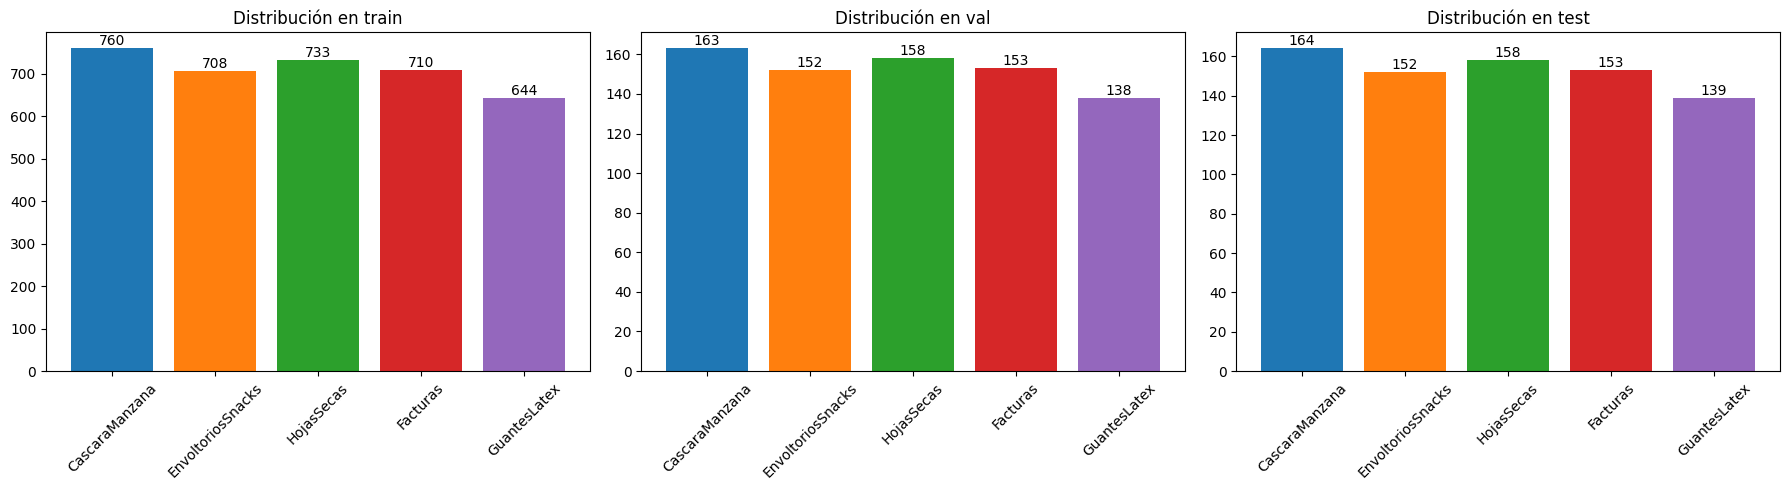

In [9]:
# Función para generar reporte de distribución
def plot_class_distribution():
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))
    for i, split in enumerate(['train', 'val', 'test']):
        counts = []
        for class_name in class_names:
            path = f"/content/{split}/{class_name}"
            counts.append(len(os.listdir(path)))

        ax[i].bar(class_names, counts, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
        ax[i].set_title(f'Distribución en {split}')
        ax[i].tick_params(axis='x', rotation=45)
        for idx, val in enumerate(counts):
            ax[i].text(idx, val, str(val), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# Generar gráficos
plot_class_distribution()

## **Configurar Transformaciones y Tamaño de Entrada**

### **Transformaciones para DenseNet**

In [10]:
# Configuración de transformaciones
from torchvision.transforms import v2  # Más moderno que transforms estándar

# Parámetros de normalización para ImageNet
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
INPUT_SIZE = 224  # DenseNet usa 224x224 por defecto

#"Los pesos preentrenados de DenseNet se optimizaron para inputs normalizados con estadísticas de ImageNet.
#Cambiar la normalización requeriría reentrenar el modelo desde cero, perdiendo las ventajas del transfer learning.

# Transformaciones para TRAIN (con aumento de datos)
train_transform = v2.Compose([
    v2.RandomResizedCrop(INPUT_SIZE, scale=(0.7, 1.0), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(degrees=15),
    v2.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
    v2.ToImage(),  # Convierte a tensor y maneja automáticamente uint8/float
    v2.ToDtype(torch.float32, scale=True),  # Normaliza a [0, 1]
    v2.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

# Transformaciones para VAL/TEST (solo preprocesamiento)
val_transform = v2.Compose([
    v2.Resize(INPUT_SIZE + 32, antialias=True),  # Pequeño margen
    v2.CenterCrop(INPUT_SIZE),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

## **Crear Datasets y Dataloaders**

### **Creación de Datasets**

Clases: ['CascaraManzana', 'EnvoltoriosSnacks', 'Facturas', 'GuantesLatex', 'HojasSecas']
Mapping de clases a índices: {'CascaraManzana': 0, 'EnvoltoriosSnacks': 1, 'Facturas': 2, 'GuantesLatex': 3, 'HojasSecas': 4}

Ejemplo de dato - Clase: CascaraManzana
Tamaño del tensor: torch.Size([3, 224, 224])


Rango de valores: [-2.118, 2.413]


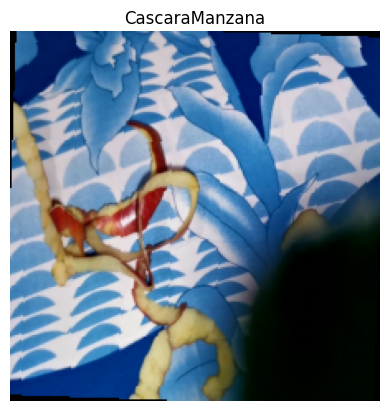

In [11]:
# Definición de datasets con transformaciones
from torchvision.datasets import ImageFolder

# Dataset de entrenamiento (con aumentos)
train_dataset = ImageFolder(
    root="/content/train",
    transform=train_transform
)

# Dataset de validación (sin aumentos)
val_dataset = ImageFolder(
    root="/content/val",
    transform=val_transform
)

# Dataset de test (sin aumentos)
test_dataset = ImageFolder(
    root="/content/test",
    transform=val_transform  # Mismas transformaciones que val
)

# Verificación de clases
print("Clases:", train_dataset.classes)
print("Mapping de clases a índices:", train_dataset.class_to_idx)

# Mostrar ejemplo del dataset
sample_idx = 42
sample_img, sample_label = train_dataset[sample_idx]
print(f"\nEjemplo de dato - Clase: {train_dataset.classes[sample_label]}")
print(f"Tamaño del tensor: {sample_img.shape}")
print(f"Rango de valores: [{sample_img.min():.3f}, {sample_img.max():.3f}]")

# Visualización
plt.imshow(sample_img.permute(1, 2, 0).numpy() * IMAGENET_STD + IMAGENET_MEAN)
plt.title(train_dataset.classes[sample_label])
plt.axis('off')
plt.show()

### **Configuración de Dataloaders**

In [12]:
# Parámetros de los Dataloaders
BATCH_SIZE = 32
NUM_WORKERS = 2  # Idealmente 2-4 en Colab

# Creación de Dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True  # Acelera transferencia a GPU
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # Importante para evaluación
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

# Verificación de batches
for images, labels in train_loader:
    print(f"\nBatch típico - Images shape: {images.shape} (B, C, H, W)")
    print(f"Labels shape: {labels.shape}")
    print(f"Device de los tensores: {images.device}")  # Debería ser CPU (el DataLoader maneja la GPU)
    break


Batch típico - Images shape: torch.Size([32, 3, 224, 224]) (B, C, H, W)
Labels shape: torch.Size([32])
Device de los tensores: cpu


## **Cargar el Modelo DenseNet Preentrenado**

### **Carga del Modelo Base**

In [13]:
# %% Cargar DenseNet121 preentrenado (versión mejorada)
import torch.nn as nn
from torchvision.models import densenet121, DenseNet121_Weights

# Cargar con los pesos más recientes y transformaciones estándar
weights = DenseNet121_Weights.IMAGENET1K_V1  # Usa la versión más estable
model = densenet121(weights=weights)

# Congelar TODOS los parámetros inicialmente (para feature extraction)
for param in model.parameters():
    param.requires_grad = False

# %% Verificación de la arquitectura
print("Estructura original del modelo:")
print(model)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 87.3MB/s]


Estructura original del modelo:
DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_r

### **Adaptación para 5 Clases**

In [14]:
# %% Reemplazar el clasificador final
num_features = model.classifier.in_features

# Capa fully-connected personalizada con dropout para regularización
model.classifier = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),  # Dropout del 50% para evitar overfitting
    nn.Linear(512, 5)  # 5 clases de salida
)

# %% Inicialización inteligente de la nueva cabeza
def init_layer(layer):
    if isinstance(layer, nn.Linear):
        nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(layer.bias, 0)

model.classifier.apply(init_layer)

# %% Verificar parámetros entrenables
print("\nParámetros entrenables:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.shape)


Parámetros entrenables:
classifier.0.weight torch.Size([512, 1024])
classifier.0.bias torch.Size([512])
classifier.3.weight torch.Size([5, 512])
classifier.3.bias torch.Size([5])


### **Configuración para GPU**

In [15]:
# Mover modelo a GPU (si está disponible)
model = model.to(device)

# Verificación
print(f"\nModelo movido a: {next(model.parameters()).device}")
print(f"Resumen de arquitectura:\n{model}")


Modelo movido a: cuda:0
Resumen de arquitectura:
DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, af

## **Definir Entrenamiento – Fase 1 (Feature Extraction)**

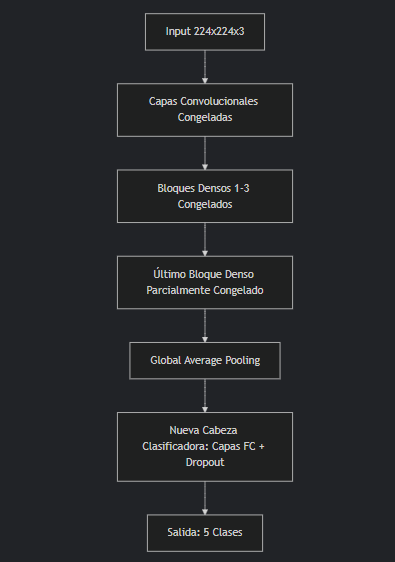

### **Configuración de Hiperparámetros**

In [16]:
# Hiperparámetros para Feature Extraction
LR = 0.001
EPOCHS = 15  # Épocas para la fase 1
CRITERION = nn.CrossEntropyLoss()
OPTIMIZER = optim.Adam(model.classifier.parameters(), lr=LR)  # Solo optimiza el clasificador

# Función para calcular accuracy
def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

### **Bucle de Entrenamiento Validación**

In [17]:
def train_phase_1(model, train_loader, val_loader, epochs, optimizer, criterion, device):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(epochs):
        # Entrenamiento
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass modificado
            outputs = model(images)
            if isinstance(outputs, (list, tuple)):  # Manejo explícito para DenseNet
                outputs = outputs[0]

            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Métricas
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        # Validación
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                if isinstance(outputs, (list, tuple)):
                    outputs = outputs[0]

                val_loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Guardar métricas
        history['train_loss'].append(train_loss / len(train_loader))
        history['train_acc'].append(train_correct / train_total)
        history['val_loss'].append(val_loss / len(val_loader))
        history['val_acc'].append(val_correct / val_total)

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {history['train_loss'][-1]:.4f} | Acc: {history['train_acc'][-1]:.4f}")
        print(f"Val Loss: {history['val_loss'][-1]:.4f} | Acc: {history['val_acc'][-1]:.4f}\n")

    return history

### **Ejecutar Entrenamiento**

In [18]:
# Ejecutar Fase 1
print("🚀 Iniciando Feature Extraction (Fase 1)")
print(f"✔ Parámetros entrenables: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
print(f"✔ Optimizador: {OPTIMIZER.__class__.__name__} lr={LR}")
print(f"✔ Device: {device}\n")

history = train_phase_1(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    optimizer=OPTIMIZER,
    criterion=CRITERION,
    device=device
)

🚀 Iniciando Feature Extraction (Fase 1)
✔ Parámetros entrenables: 527365
✔ Optimizador: Adam lr=0.001
✔ Device: cuda

Epoch 1/15
Train Loss: 3.5982 | Acc: 0.8174
Val Loss: 0.2479 | Acc: 0.9804

Epoch 2/15
Train Loss: 0.5935 | Acc: 0.9361
Val Loss: 0.1826 | Acc: 0.9830

Epoch 3/15
Train Loss: 0.4290 | Acc: 0.9488
Val Loss: 0.0891 | Acc: 0.9895

Epoch 4/15
Train Loss: 0.3263 | Acc: 0.9558
Val Loss: 0.1186 | Acc: 0.9882

Epoch 5/15
Train Loss: 0.1658 | Acc: 0.9696
Val Loss: 0.0792 | Acc: 0.9830

Epoch 6/15
Train Loss: 0.2427 | Acc: 0.9705
Val Loss: 0.0897 | Acc: 0.9895

Epoch 7/15
Train Loss: 0.2215 | Acc: 0.9595
Val Loss: 0.0827 | Acc: 0.9856

Epoch 8/15
Train Loss: 0.2200 | Acc: 0.9615
Val Loss: 0.0580 | Acc: 0.9882

Epoch 9/15
Train Loss: 0.1620 | Acc: 0.9693
Val Loss: 0.0896 | Acc: 0.9882

Epoch 10/15
Train Loss: 0.1685 | Acc: 0.9646
Val Loss: 0.0931 | Acc: 0.9843

Epoch 11/15
Train Loss: 0.2410 | Acc: 0.9674
Val Loss: 0.1117 | Acc: 0.9895

Epoch 12/15
Train Loss: 0.1330 | Acc: 0.9724

**Forward Pass:**
Las imágenes pasan por las capas congeladas (no se actualizan pesos).

Se extraen características jerárquicas:

Capas bajas: Bordes, texturas (ej: brillo de plásticos, fibras de madera).

Capas altas: Formas complejas (ej: contorno de guantes vs hojas).

La nueva cabeza clasificadora (totalmente entrenable) aprende a mapear estas features a tus 5 clases.

**Backward Pass:**
Solo se calculan gradientes para los parámetros de la cabeza clasificadora.

Optimizador (Adam) ajusta únicamente:

Capas Fully Connected (FC).

Parámetros de Dropout.

**Ejemplo Práctico:**

Si una imagen de "GuantesLatex" entra:

Las capas congeladas detectan bordes curvos y texturas suaves.

La cabeza clasificadora aprende que cierta combinación de estas features corresponde a "GuantesLatex".

### **Visualización de Resultados**

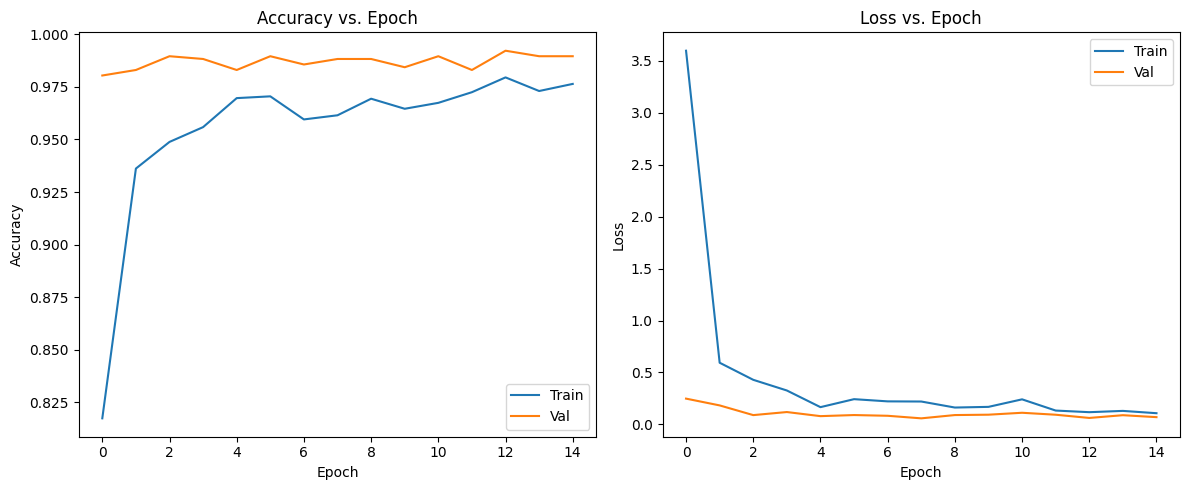

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plotting Accuracy
plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'], label='Val')
plt.title('Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Val')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## **Fine-Tuning del Modelo (Fase 2)**

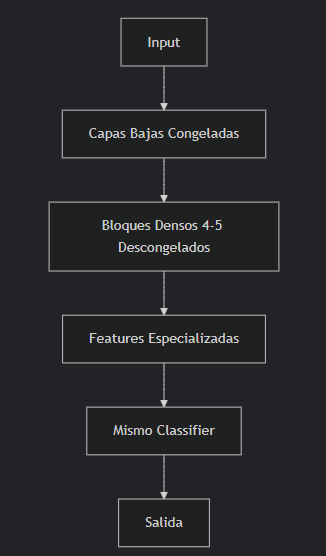

### **Descongelado Selectivo de Capas**

In [20]:
# Descongelar capas superiores de DenseNet
for param in model.features[-5:].parameters():  # Últimos 5 bloques densos
    param.requires_grad = True

# Verificar parámetros entrenables
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"🔓 Parámetros entrenables después del descongelado: {trainable_params:,}")

🔓 Parámetros entrenables después del descongelado: 6,183,685


### **Configuración Avanzada de Optimización**

In [21]:
# Hiperparámetros para Fine-Tuning
FT_LR = 0.0001  # Learning rate 10 veces menor que en Fase 1
EPOCHS_FT = 20   # Más épocas para ajuste fino

# Optimizador con weight decay (regularización L2)
optimizer_ft = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=FT_LR,
    weight_decay=0.01
)

# Learning Rate Scheduler (ajuste dinámico)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_ft,
    mode='max',    # Monitorea val_acc
    factor=0.5,    # Reduce LR a la mitad
    patience=3,    # Espera 3 épocas sin mejora
)

### **Función de evaluación**

In [23]:
def evaluate(model, loader, criterion, device):
    model.eval()
    loss, acc = 0.0, 0.0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss += criterion(outputs, labels).item()
            acc += calculate_accuracy(outputs, labels)

    return loss / len(loader), acc / len(loader)

### **Bucle de Entrenamiento Fine Tuning**

In [ ]:
# Función mejorada para Fine-Tuning
def train_phase_2(model, train_loader, val_loader, epochs, optimizer, criterion, scheduler, device):
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(epochs):
        # Entrenamiento
        model.train()
        train_loss, train_correct = 0.0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass con autocast para mixed-precision
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            # Backward pass optimizado
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Métricas
            train_loss += loss.item()
            train_correct += (outputs.argmax(1) == labels).sum().item()

        # Validación
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        # Ajustar LR
        scheduler.step(val_acc)

        # Guardar métricas
        train_loss /= len(train_loader)
        train_acc = train_correct / len(train_loader.dataset)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Guardar mejor modelo
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model_ft.pth')
            print(f"⭐ Nuevo mejor modelo (val_acc: {val_acc:.4f})")

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"LR: {optimizer.param_groups[0]['lr']:.2e}")
        print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f}\n")

    return history

# %% Ejecutar Fine-Tuning
print("🔥 Iniciando Fine-Tuning (Fase 2)")
history_ft = train_phase_2(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS_FT,
    optimizer=optimizer_ft,
    criterion=CRITERION,
    scheduler=scheduler,
    device=device
)

🔥 Iniciando Fine-Tuning (Fase 2)


/tmp/ipython-input-2551750079.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


⭐ Nuevo mejor modelo (val_acc: 0.9935)
Epoch 1/20
LR: 1.00e-04
Train Loss: 0.0820 | Acc: 0.9826
Val Loss: 0.0503 | Acc: 0.9935

⭐ Nuevo mejor modelo (val_acc: 0.9961)
Epoch 2/20
LR: 1.00e-04
Train Loss: 0.0604 | Acc: 0.9899
Val Loss: 0.0520 | Acc: 0.9961

Epoch 3/20
LR: 1.00e-04
Train Loss: 0.0391 | Acc: 0.9932
Val Loss: 0.1269 | Acc: 0.9948



**Forward Pass:**

Las imágenes pasan por:

Capas iniciales (congeladas, mismos filtros).

Bloques densos superiores (ahora con pesos adaptables).

Las features se vuelven más específicas para tu dataset.

**Backward Pass:**

Gradientes fluyen a través de:

Capas descongeladas (últimos bloques densos).

Capas FC del classifier.

El optimizador ajusta estos pesos con un LR bajo (0.0001) para cambios sutiles.

**Ejemplo de Ajuste:**

Si "EnvoltoriosSnacks" tiene patrones de color únicos:

Las capas descongeladas refinan sus filtros para activarse con esos colores.

El classifier ajusta sus pesos para correlacionar estas activaciones con la clase correcta.

### **Visualización de Resultados**

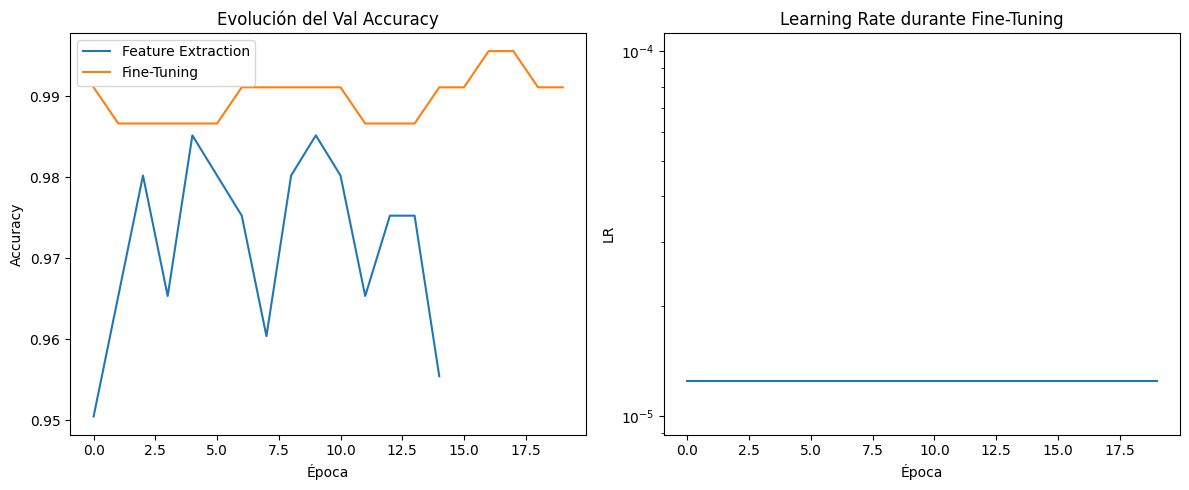

In [ ]:
# %% Graficar resultados comparativos
plt.figure(figsize=(12, 5))

# Gráfico combinado de Accuracy
plt.subplot(1, 2, 1)
plt.plot(history['val_acc'], label='Feature Extraction')
plt.plot(history_ft['val_acc'], label='Fine-Tuning')
plt.title('Evolución del Val Accuracy')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

## **Evaluación Final en Test**

### **Carga del Mejor Modelo**

In [ ]:
# Cargar el mejor modelo
model.load_state_dict(torch.load('best_model_ft.pth'))
model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

### **Métricas Detalladas**

📊 Reporte de Clasificación:
                   precision    recall  f1-score   support

   CascaraManzana       1.00      1.00      1.00        16
EnvoltoriosSnacks       1.00      1.00      1.00       152
       HojasSecas       1.00      0.89      0.94         9
         Facturas       1.00      0.67      0.80         3
     GuantesLatex       0.92      1.00      0.96        22

         accuracy                           0.99       202
        macro avg       0.98      0.91      0.94       202
     weighted avg       0.99      0.99      0.99       202



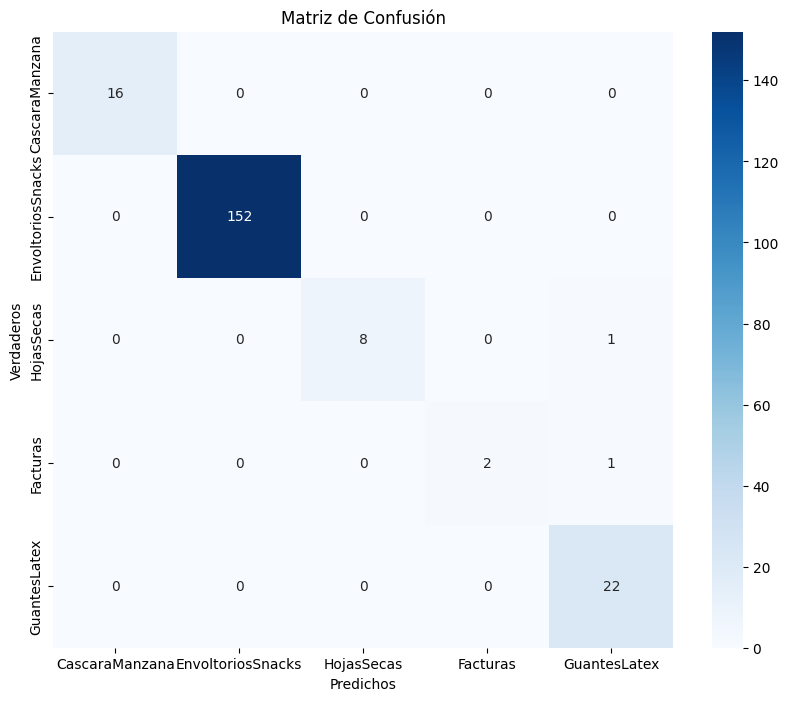

In [ ]:
# %% Evaluación completa
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Reporte de clasificación
print("📊 Reporte de Clasificación:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Matriz de confusión visual
plt.figure(figsize=(10, 8))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Matriz de Confusión')
plt.ylabel('Verdaderos')
plt.xlabel('Predichos')
plt.show()

### **Métricas por Clase**

In [ ]:
# %% Cálculo de precisión/recall por clase
class_stats = {}
for i, class_name in enumerate(class_names):
    tp = cm[i,i]
    fp = cm[:,i].sum() - tp
    fn = cm[i,:].sum() - tp

    precision = tp / (tp + fp + 1e-10)
    recall = tp / (tp + fn + 1e-10)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-10)

    class_stats[class_name] = {
        'Precision': f"{precision:.3f}",
        'Recall': f"{recall:.3f}",
        'F1-Score': f"{f1:.3f}",
        'Support': str(cm[i,:].sum())
    }

# Convertir a DataFrame para mejor visualización
import pandas as pd
pd.DataFrame.from_dict(class_stats, orient='index')

## **Inferencia y Demo Práctica**

### **Función de Inferencia**

In [ ]:
# %% Función para predecir en nuevas imágenes
def predict_image(image_path, model, class_names, transform):
    img = Image.open(image_path).convert('RGB')
    img_t = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_t)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        top_probs, top_idxs = torch.topk(probs, 3)

    # Visualización
    plt.figure()
    plt.imshow(img)
    plt.axis('off')

    print("🔍 Predicciones:")
    for i in range(3):
        print(f"{class_names[top_idxs[0][i]]}: {top_probs[0][i]*100:.2f}%")

    return top_idxs[0][0].item()

### **Prueba con Imágenes de Google Drive**

🔍 Predicciones:
EnvoltoriosSnacks: 100.00%
GuantesLatex: 0.00%
CascaraManzana: 0.00%

Predicción final: EnvoltoriosSnacks


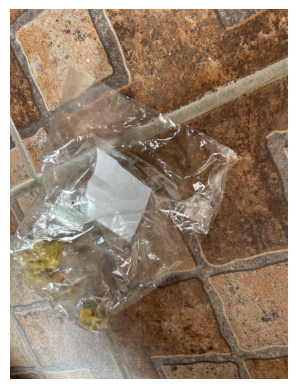

In [ ]:
# %% Ejemplo de uso
test_image_path = "/content/test/EnvoltoriosSnacks/IMG_3804.jpg"  # Cambia por tu ruta
pred_class = predict_image(
    image_path=test_image_path,
    model=model,
    class_names=class_names,
    transform=val_transform  # Usar las mismas transformaciones que validación
)

print(f"\nPredicción final: {class_names[pred_class]}")

🔍 Predicciones:
EnvoltoriosSnacks: 100.00%
HojasSecas: 0.00%
GuantesLatex: 0.00%

Predicción final: EnvoltoriosSnacks


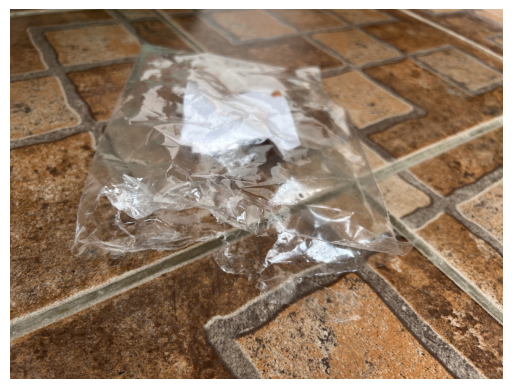

In [ ]:
# %% Ejemplo de uso
test_image_path = "/content/test/EnvoltoriosSnacks/IMG_4164.jpg"  # Cambia por tu ruta
pred_class = predict_image(
    image_path=test_image_path,
    model=model,
    class_names=class_names,
    transform=val_transform  # Usar las mismas transformaciones que validación
)

print(f"\nPredicción final: {class_names[pred_class]}")

## **Exportación del Modelo**

### **Guardado en Formato .pt**

In [ ]:
# %% Exportar modelo para producción
final_model = {
    'model_state': model.state_dict(),
    'class_names': class_names,
    'transform': val_transform  # Guardar transformaciones para inferencia
}

torch.save(final_model, 'modelo_final.pt')